In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import pims
from parameter_estimation import plot_parameter
from frames import extract_frames
from tracking import batch, track
from scipy.optimize import curve_fit

<Figure size 640x480 with 0 Axes>

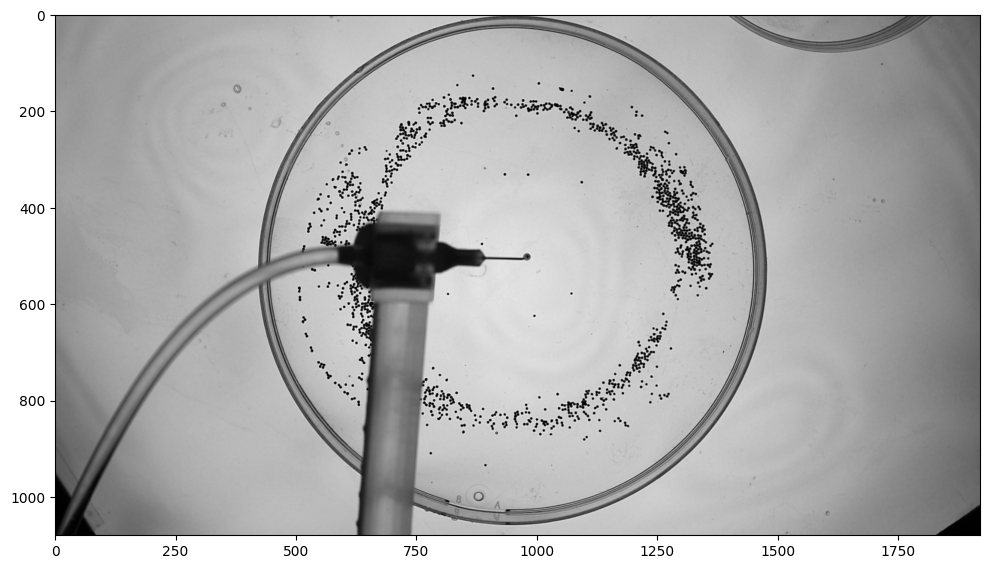

<Figure size 640x480 with 0 Axes>

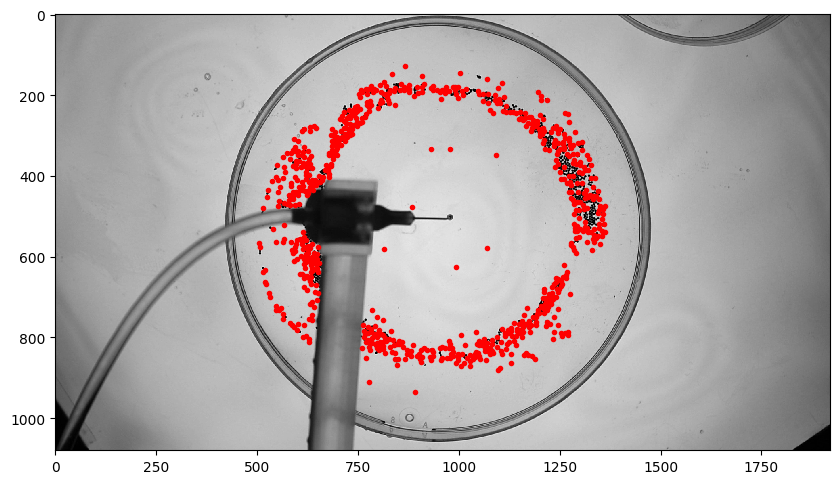

c:\Users\escud\Desktop\Marangoni\Code\marangoni-spreading\.venv\Lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


<Figure size 640x480 with 0 Axes>

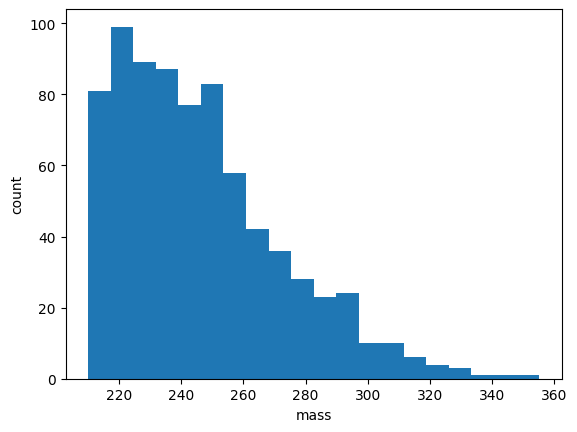

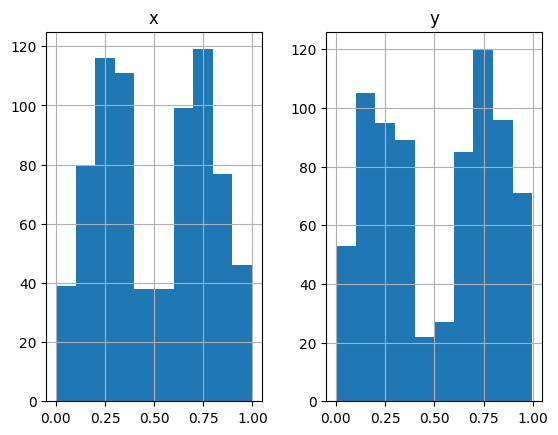

In [2]:
directory = "C:/Users/escud/Desktop/Marangoni/Videos/0124-Experiments/003_frames/"
last_frame = 300
diameter = 5
mass = 210

frames = plot_parameter(directory, particle_diameter=diameter, particle_minmass=mass, frame_number=last_frame)

In [3]:
output_path = "C:/Users/escud/Desktop/Marangoni/Videos/0124-Experiments/003_frames_output/"
f = batch(frames[:last_frame], particle_diameter=diameter, particle_minmass=mass, save_video=False, output_path=output_path)

Frame 299: 735 features


Frame 299: 735 trajectories present.


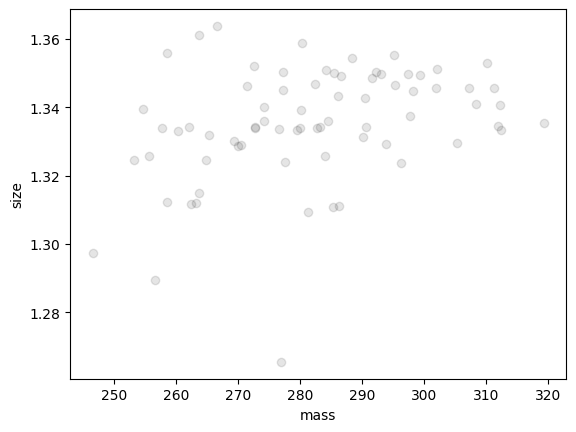

<Figure size 640x480 with 0 Axes>

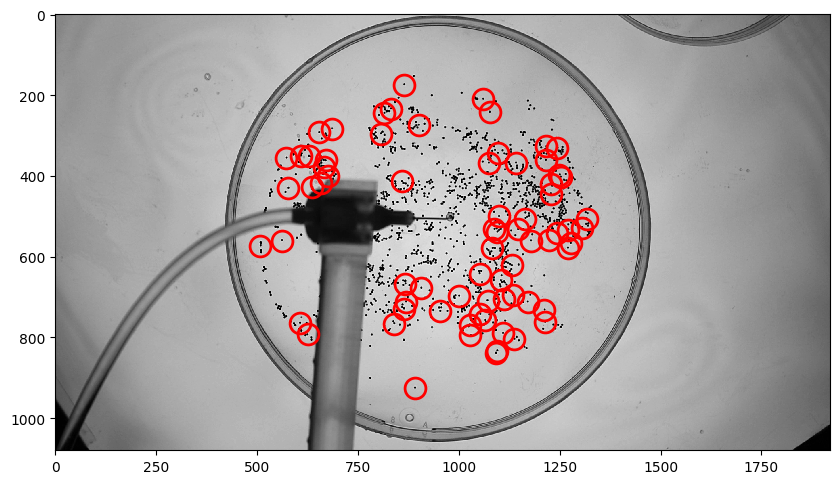

No-filter: 13851
Pre-filter: 73
Filter: 73


In [4]:
status = False
filtered_trajectories = track(batched_frames=f, frames=frames[:last_frame], particle_diameter=diameter, particle_minmass=mass, filter_frame_number=len(frames[:last_frame]), save_video=status, output_path=output_path)

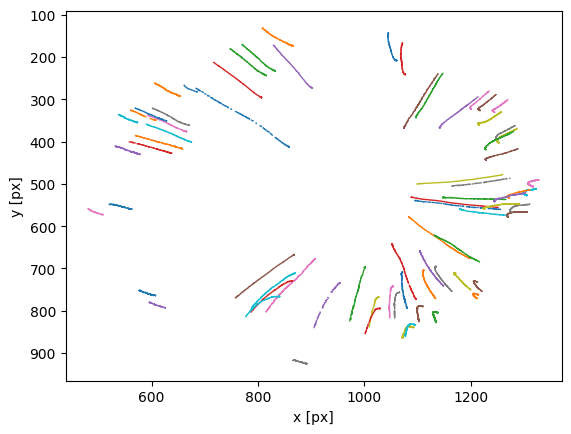

frame
0      72
1      72
2      72
3      72
4      72
       ..
295    72
296    71
297    72
298    71
299    71
Name: count, Length: 300, dtype: int64
0.020828611187846728
8


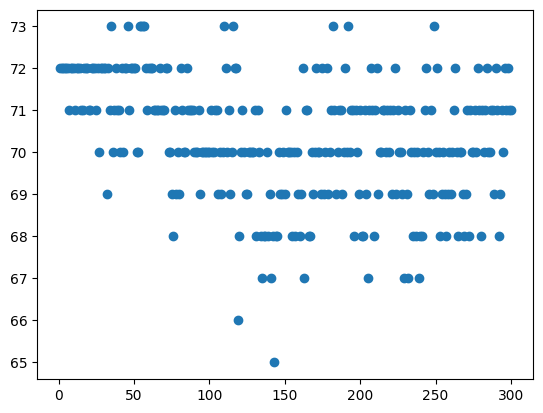

In [5]:
# plt.figure(3)
# tp.plot_traj(filtered_trajectories)

d = tp.compute_drift(filtered_trajectories)
# d.plot()
# plt.show()

tm = tp.subtract_drift(filtered_trajectories.copy(), d)
ax = tp.plot_traj(tm)
plt.show()

particles_per_frame = tm['frame'].value_counts().sort_index()

frame_number_array = np.linspace(1, len(particles_per_frame), len(particles_per_frame))
y_arr = tm['frame'].value_counts().sort_index()
print(y_arr)

plt.scatter(frame_number_array, y_arr)
print(np.std(y_arr) / np.mean(y_arr))
print(max(y_arr) - min(y_arr))

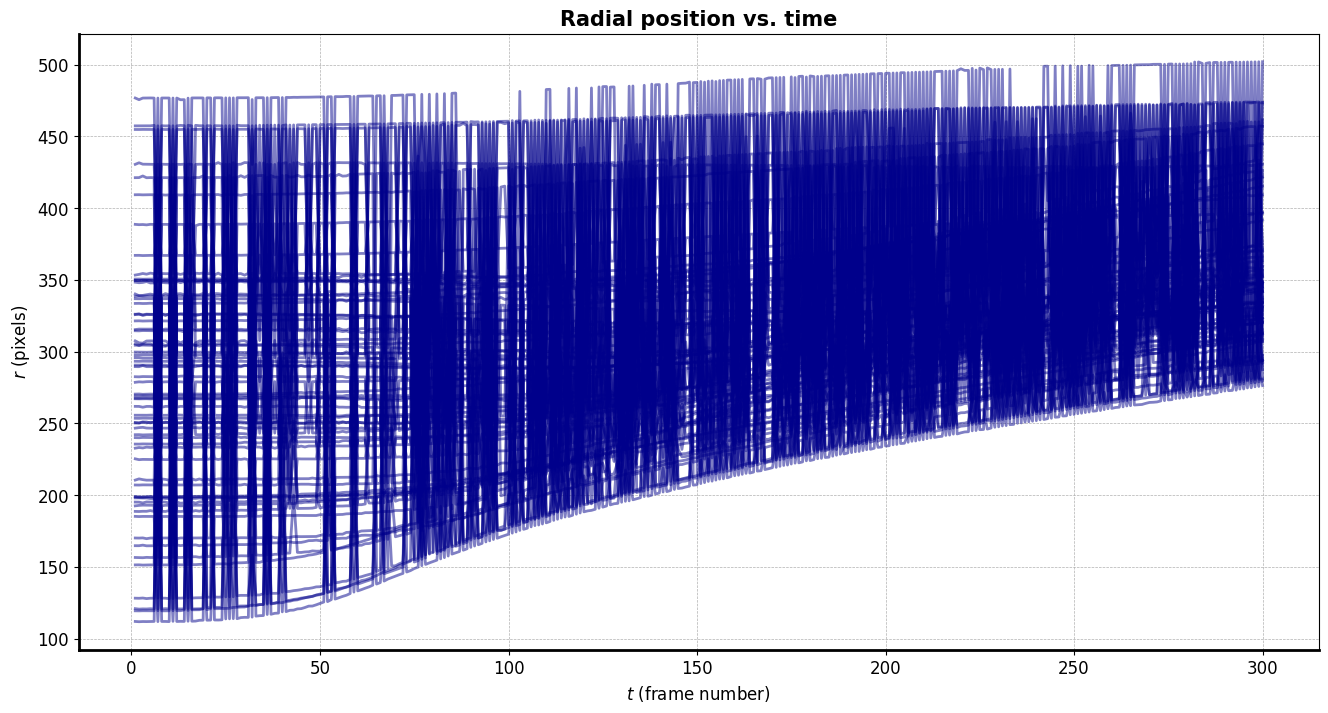

In [7]:
min_particles = 10000
for i in y_arr:
    if i < min_particles:
        min_particles = i

x_array = []
y_array = []
for i in range(len(y_arr)):
    x_array.append((tm['x'][i].tolist()))
    y_array.append((tm['y'][i].tolist()))

x_c = 980 # determine empirically with ImageJ
y_c = 503 # determine empirically with ImageJ
r_array = [[np.sqrt((x_array[i][j] - x_c) ** 2 + (y_array[i][j] - y_c) ** 2) for j in range(len(x_array[i]))] for i in range(len(x_array))]

r_array_per_particle = []
counter_array = np.linspace(1, len(y_arr), len(y_arr))
for i in range(min_particles):
    r_array_per_particle.append([r_array[j][i] for j in range(len(r_array))])

plt.figure(figsize=(16, 8))
for i in range(len(r_array_per_particle)):
    plt.plot(counter_array, r_array_per_particle[i], linewidth=2, color='darkblue', alpha=0.5)
plt.xlabel(r'$t$ (frame number)', fontsize=12)
plt.ylabel(r'$r$ (pixels)', fontsize=12)
plt.title('Radial position vs. time', fontsize=15, fontweight='bold')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# figure_directory = "C:/Users/escud/Desktop/Marangoni/Figures/D=60mm/"
# plt.savefig(figure_directory + "Radius_vs_time_96_particles.jpeg", dpi=500, format='jpeg')
plt.show()

In [42]:
def position_speed(position_array):
    speed_array = []
    for i in range(len(position_array) - 1):
        interim = []
        for j in range(len(position_array[i])):
            interim.append(position_array[i + 1][j] - position_array[i][j])
        speed_array.append(interim)
    return speed_array

speed_array = position_speed(r_array)
selection = np.linspace(40, counter_array[-3], 5, dtype=int)

plt.figure(figsize=(16, 8))
for i in selection:
    plt.scatter(r_array[i], speed_array[i], label='t = ' + str(i) + ' frames')
plt.legend()


plt.xlabel(r'$r$ (pixels)', fontsize=12)
plt.ylabel(r'$u_s$ (pixels/frame)', fontsize=12)
plt.title('Interface velocity vs. radial position', fontsize=15, fontweight='bold')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# figure_directory = "C:/Users/escud/Desktop/Marangoni/Figures/D=60mm/"
# plt.savefig(figure_directory + "Speed_vs_radius_96_particles.jpeg", dpi=500, format='jpeg')
plt.show()

IndexError: list index out of range